# パッケージを導入します。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openvino.runtime import Core

# ONNXモデルを読み込み、コンパイルと画像の読み込み

In [2]:
# Load the OpenVINO runtime
core = Core()

# Read the ONNX model
model = core.read_model("models/yolov8s.onnx")

# Compile the model
compiled_model = core.compile_model(model, "CPU")

# Get input and output layers
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Load an image
image = cv2.imread('data/human_cat_dog2.jpg')
image = cv2.resize(image, (640, 640))

# OpenVINOを利用し、推論すること。

In [3]:
# Preprocess the image: resize, convert to blob, etc.
blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(640, 640), mean=(0, 0, 0), swapRB=True, crop=False)

# Perform forward pass
outputs = compiled_model([blob])[output_layer]

# 推論した結果の処理

In [4]:
def postprocess(outputs, img):
    boxes = []
    confidences = []
    class_ids = []

    outputs = outputs[0]  # Remove the batch dimension
    for detection in outputs.T:  # Transpose to iterate over detections
        class_scores = detection[4:]
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]
        if confidence > 0.3:
            cx, cy, w, h = detection[:4]
            box = np.array([cx - w / 2, cy - h / 2, cx + w / 2,  cy + h / 2])
            box = box.astype("int")
            boxes.append(box)
            confidences.append(float(confidence))
            class_ids.append(class_id)

    return boxes, confidences, class_ids


# 推論した画像の表示すること

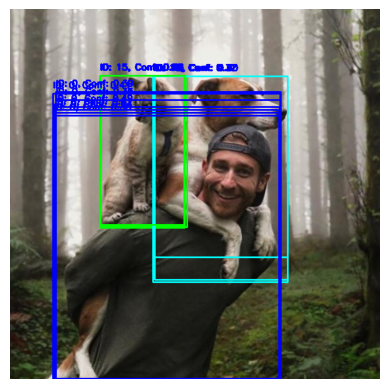

In [5]:

# Process the outputs
boxes, confidences, class_ids = postprocess(outputs, image)

# Draw the bounding boxes on the image
for box, confidence, class_id in zip(boxes, confidences, class_ids):
    if class_id == 0:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    if class_id == 15:  # COCO cat
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    if class_id == 16:  # COCO dog
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2)

    label = f'ID: {class_id}, Conf: {confidence:.2f}'
    cv2.putText(image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
